In [1]:
import torch
import torch.nn as nn
import gym
# from torchvision.transforms import Grayscale
from parameters import dotdict, MemoryBufferSimple, MemoryBufferSeparated, SensorModel, DriveDQN, model_params
from agent_torch_trans import DQN_Agent
from parameters.setup import setup_dict_trans
import environment as env_wrapper
from collections import deque
import matplotlib.pyplot as plt    
import cv2
import random
import numpy as np
from importlib.metadata import version
USE_V2 = '0.21.0' < version('gym') 
%load_ext autoreload
%autoreload 2

In [21]:
args = model_params
args.device = 'cpu'

In [3]:
def compute_steering_speed_gyro_abs(a):
    right_steering = a[6, 36:46].mean()/255
    left_steering = a[6, 26:36].mean()/255
    steering = (right_steering - left_steering + 1.0)/2
    
    left_gyro = a[6, 46:60].mean()/255
    right_gyro = a[6, 60:76].mean()/255
    gyro = (right_gyro - left_gyro + 1.0)/2
    
    speed = a[:, 0][:-2].mean()/255
    abs1 = a[:, 6][:-2].mean()/255
    abs2 = a[:, 8][:-2].mean()/255
    abs3 = a[:, 10][:-2].mean()/255
    abs4 = a[:, 12][:-2].mean()/255
    
    return [steering, speed, gyro, abs1, abs2, abs3, abs4]

def transform(s):
#     cv2.imshow('original', s)
#     cv2.waitKey(1)

    # crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    # bottom_black_bar is the section of the screen with steering, speed, abs and gyro information.
    # we crop off the digits on the right as they are illigible, even for ml.
    # since color is irrelavent, we grayscale it.
    bottom_black_bar = s[84:, 12:]
    img = cv2.cvtColor(bottom_black_bar, cv2.COLOR_RGB2GRAY)
    bottom_black_bar_bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
    bottom_black_bar_bw = cv2.resize(bottom_black_bar_bw, (84, 12), interpolation = cv2.INTER_NEAREST)
    
    # upper_field = observation[:84, :96] # this is the section of the screen that contains the track.
    upper_field = s[:84, 6:90] # we crop side of screen as they carry little information
    img = cv2.cvtColor(upper_field, cv2.COLOR_RGB2GRAY)
    upper_field_bw = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)[1]
    upper_field_bw = cv2.resize(upper_field_bw, (10, 10), interpolation = cv2.INTER_NEAREST) # re scaled to 7x7 pixels
#     cv2.imshow('video', upper_field_bw)
#     cv2.waitKey(1)
    upper_field_bw = upper_field_bw.astype('float')/255
        
    car_field = s[66:78, 43:53]
    img = cv2.cvtColor(car_field, cv2.COLOR_RGB2GRAY)
    car_field_bw = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]

#     print(car_field_bw[:, 3].mean()/255, car_field_bw[:, 4].mean()/255, car_field_bw[:, 5].mean()/255, car_field_bw[:, 6].mean()/255)
    car_field_t = [car_field_bw[:, 3].mean()/255, car_field_bw[:, 4].mean()/255, car_field_bw[:, 5].mean()/255, car_field_bw[:, 6].mean()/255]
    
#     rotated_image = rotateImage(car_field_bw, 45)
#     cv2.imshow('video rotated', rotated_image)
#     cv2.waitKey(1)

    return bottom_black_bar_bw, upper_field_bw, car_field_t

In [4]:
if USE_V2:
    env = gym.make('CarRacing-v2', new_step_api=True)
else: 
    env = gym.make('CarRacing-v0')
state_img = env.reset()

Track generation: 1147..1438 -> 291-tiles track


c:\Users\test\Documents\driving\rl_ad\env\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


In [5]:
# buffer = MemoryBufferSimple(args.n_frames, args.buffer_sz)
buffer = MemoryBufferSeparated(args.n_frames, 400)
sampler = torch.utils.data.DataLoader(buffer, batch_size=32, shuffle=True, drop_last=False)

In [6]:
state = {'img': state_img,
             'steering': 0,
             'speed': 0,
             'gyro': 0,
             'abs1': 0,
             'abs2': 0,
             'abs3': 0,
             'abs4': 0,
             'action_idx': 0}
buffer.add_experience(state, 0, 0, False, new_episode=True) # too add new episode
state_frame_stack = deque(maxlen=args.n_frames)

for i in range(100):
    if USE_V2:
        state_img, reward, terminated, truncated, info = env.step((0.1,1,0))
        done = terminated or truncated 
    else:
        state_img, reward, done, info = env.step((0.1,1,0))
    state_img = state_img/255.0 
    data_board = state_img[84:, 12:]
    steering, speed, gyro, abs1, abs2, abs3, abs4 = compute_steering_speed_gyro_abs(data_board)
    action_idx = random.randint(0, args.act_dim-1)
    state = {'img': state_img,
             'steering': steering,
             'speed': speed,
             'gyro': gyro,
             'abs1': abs1,
             'abs2': abs2,
             'abs3': abs3,
             'abs4': abs4,
             'action_idx': action_idx}
    state_frame_stack.append(state)
    buffer.add_experience(state, action_idx, reward, done)

state_img.shape, reward, done, info

((96, 96, 3), -0.09999999999999964, False, {})

In [7]:
buffer.ep_lengths

deque([101])

In [8]:
sensor_net = SensorModel(args.in_channels, args.h_size,
                         p=args.c_dropout, image_shape=args.img_shape)
states, actions, rewards, dones = next(iter(sampler))

In [9]:
print(list(map(lambda x:x.shape, states)))

[torch.Size([32, 2, 3, 96, 96]), torch.Size([32, 2, 1]), torch.Size([32, 2, 1]), torch.Size([32, 2, 1]), torch.Size([32, 2, 1]), torch.Size([32, 2, 1]), torch.Size([32, 2, 1]), torch.Size([32, 2, 1]), torch.Size([32, 2])]


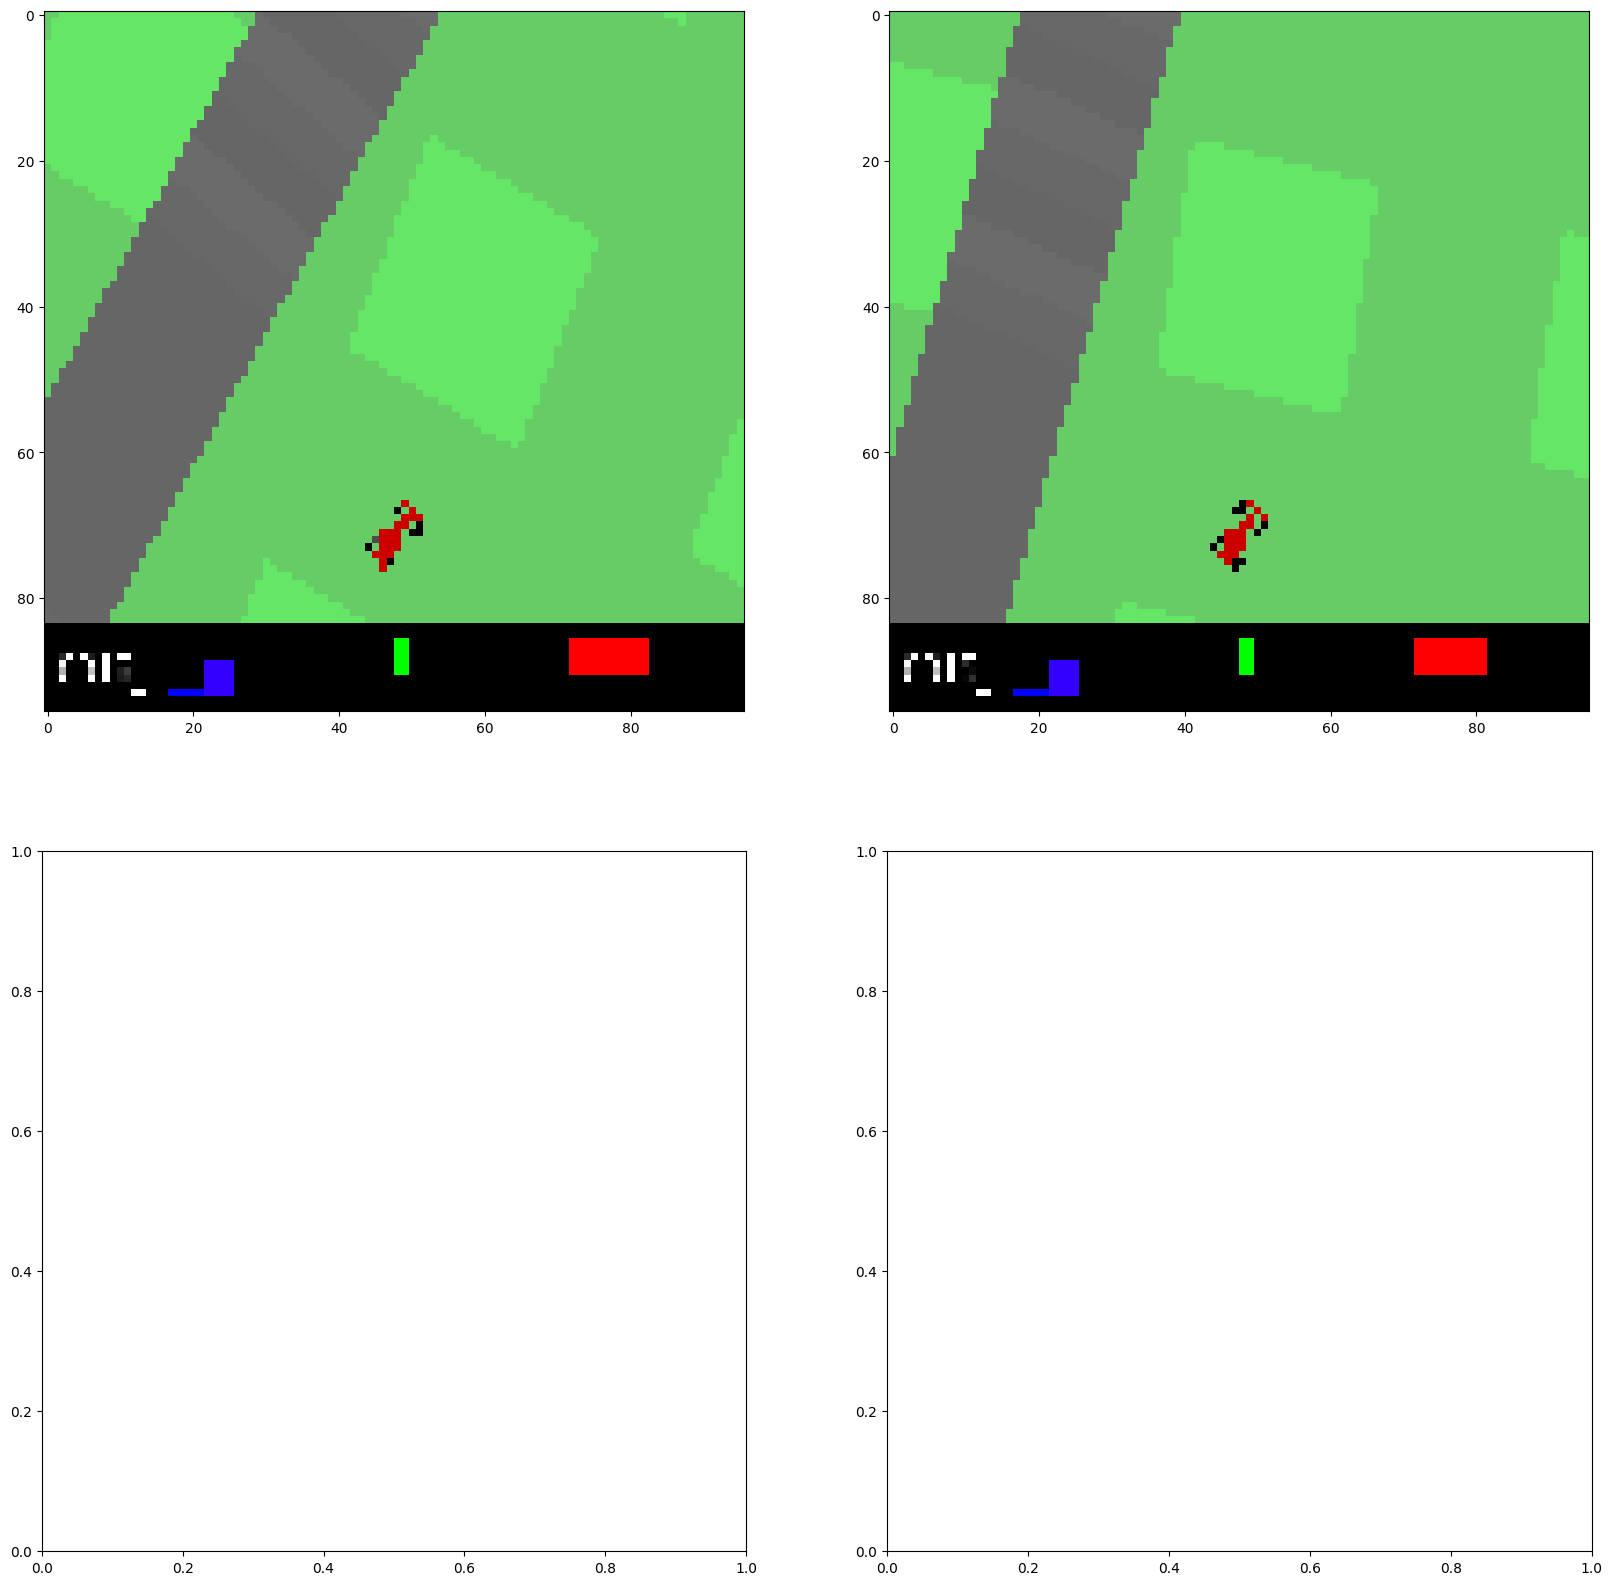

In [10]:
nrows, ncols = 2,2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))
batch_idx = 4
for i in range(args.n_frames+1):
    r = i // nrows
    c = i % ncols
    axs[r][c].imshow(states[0][batch_idx,i,:,:].squeeze(0).permute(1,2,0))

In [13]:
frame_idx = 0 
X_img = states[0].transpose(0,1).to(args.device)
X_sensor = torch.stack(states[1:-1], axis=0).permute(0,2,1,3).to(args.device)
X_act = states[-1].transpose(0,1).to(args.device)
actions = actions.unsqueeze(-1).to(args.device)
rewards = rewards.unsqueeze(1).to(args.device)
dones = dones.unsqueeze(1).to(args.device)
X_img.shape, X_sensor.shape, X_act.shape, actions.shape, rewards.shape, dones.shape, X_img[frame_idx].shape, X_sensor[:,frame_idx].shape

(torch.Size([2, 32, 3, 96, 96]),
 torch.Size([7, 2, 32, 1]),
 torch.Size([2, 32]),
 torch.Size([32, 1, 1]),
 torch.Size([32, 1, 1]),
 torch.Size([32, 1, 1]),
 torch.Size([32, 3, 96, 96]),
 torch.Size([7, 32, 1]))

In [14]:
sensor_hs = sensor_net(X_img[frame_idx], X_sensor[:,frame_idx])
X_img_h, X_steering_h, X_speed_h, X_gyro_h, X_abs1_h, X_abs2_h, X_abs3_h, X_abs4_h = sensor_net(X_img[frame_idx], X_sensor[:,frame_idx])

In [15]:
X_img_h.shape, X_steering_h.shape, X_speed_h.shape, X_gyro_h.shape, X_abs1_h.shape, X_abs2_h.shape, X_abs3_h.shape, X_abs4_h.shape

(torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 128]))

In [16]:
torch.stack(sensor_hs, axis=0).shape

torch.Size([8, 32, 128])

In [17]:
drive_net = DriveDQN(args)
drive_net.to(args.device)

DriveDQN(
  (sensor_net): SensorModel(
    (cnn): Nature_Paper_Conv_Dropout_Torch(
      (layer1_cnn): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
      (layer2_cnn): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (layer3_cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (layer_4_dense): Linear(in_features=9216, out_features=512, bias=True)
      (out_layer): Linear(in_features=512, out_features=128, bias=True)
    )
    (steering): Linear(in_features=1, out_features=128, bias=True)
    (speed): Linear(in_features=1, out_features=128, bias=True)
    (gyro): Linear(in_features=1, out_features=128, bias=True)
    (abs1): Linear(in_features=1, out_features=128, bias=True)
    (abs2): Linear(in_features=1, out_features=128, bias=True)
    (abs3): Linear(in_features=1, out_features=128, bias=True)
    (abs4): Linear(in_features=1, out_features=128, bias=True)
  )
  (fusion_net): Transformer(
    (encoder): TransformerEn

In [18]:
drive_net(X_img.to(args.device), X_sensor.to(args.device), X_act.to(args.device)).shape

torch.Size([32, 5])

# Testing Agent Setup

In [16]:
environment = env_wrapper.CarRacing(**setup_dict_trans['car racing'])
control = DQN_Agent(environment=environment, **setup_dict_trans['agent'])

In [17]:
control.get_action(state_frame_stack, 0)

4

In [18]:
buffer_ = control.replay_memory 
# populate buffer from above
for i in range(len(buffer.states)):
    buffer_.add_experience(buffer.states[i], buffer.actions[i], 
                           buffer.rewards[i], buffer.dones[i]) 
control.replay_memory_sampler.sampler.num_samples

95

In [19]:
control.experience_replay()

In [20]:
DriveDQN.__name__

'DriveDQN'

In [21]:
sum((p.numel() for p in control.dqn.parameters()))

5058157

In [22]:
sum((p.numel() for p in control.dqn.sensor_net.parameters()))

4862496

In [23]:
sum((p.numel() for p in control.dqn.sensor_net.cnn.parameters()))

4860704

In [62]:
from parameters.drive_net import DriveDQN_simple_fusion2_lstm as driveArc

In [63]:
drive_net = driveArc(args)

In [65]:
out = drive_net(X_img.to(args.device)[:-1], X_sensor.to(args.device)[:,:-1], X_act[:-1].to(args.device))
out.shape

torch.Size([32, 5])

In [61]:
sum((p.numel() for p in drive_net.parameters()))

5208613

In [115]:
states[0].shape, actions.shape, rewards.shape, dones.shape

(torch.Size([1, 5, 3, 96, 96]),
 torch.Size([1]),
 torch.Size([1]),
 torch.Size([1]))

In [144]:
X_img = states[0].transpose(0,1).to(args.device)
X_sensor = torch.stack(states[1:-1], axis=0).permute(0,2,1).unsqueeze(-1).to(args.device)
X_act = states[-1].transpose(0,1).to(args.device)
cur_state = (X_img[:-1], X_sensor[:,:-1], X_act[:-1])
next_state = (X_img[1:], X_sensor[:, 1:], X_act[1:])
actions = actions.unsqueeze(-1).to(args.device)
rewards = rewards.unsqueeze(1).to(args.device)
dones = dones.unsqueeze(1).to(args.device)
X_img.shape, X_act.shape, actions.shape, rewards.shape, dones.shape, cur_state[0].shape, next_state[0].shape

(torch.Size([5, 2, 3, 96, 96]),
 torch.Size([5, 2]),
 torch.Size([2, 1]),
 torch.Size([2, 1]),
 torch.Size([2, 1]),
 torch.Size([4, 2, 3, 96, 96]),
 torch.Size([4, 2, 3, 96, 96]))

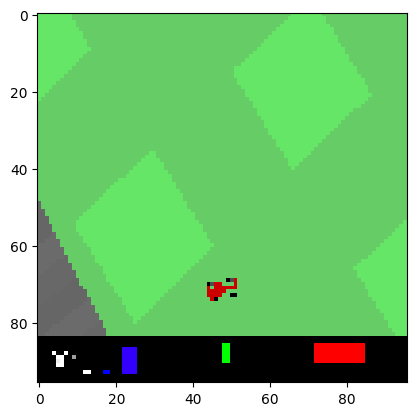

In [154]:
plt.imshow(X_img[0,0].permute(1,2,0).numpy())

In [156]:
grey_scaler = Grayscale(num_output_channels=1)
X = grey_scaler(X_img).squeeze(2).transpose(0,1)
X.shape

torch.Size([2, 5, 96, 96])

In [167]:
X[0,:3].permute(1,2,0).shape

torch.Size([96, 96, 3])

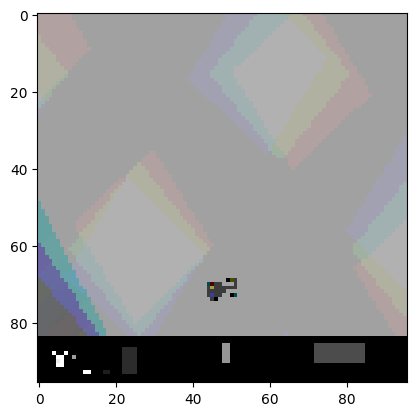

In [174]:
plt.imshow(X[0,0:3].permute(1,2,0).numpy())

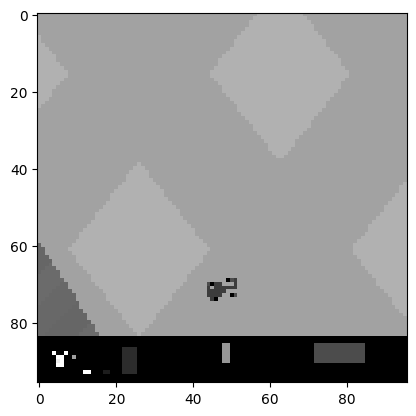

In [187]:
plt.imshow(X[0,1].numpy(), cmap="gray")

In [178]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

In [145]:
greedy_actions = drive_net(*next_state).argmax(dim=1, keepdims=True)
greedy_actions

tensor([[2],
        [4]])

In [152]:
q_value_targets = rewards + 0.99 * ((1 - dones) * drive_net(*next_state))
q_value_targets.shape

torch.Size([2, 5])

In [ ]:
q_value_targets = q_value_targets.gather(1, greedy_actions)

In [148]:
q_value_targets

tensor([[-0.0926],
        [-0.0852]], grad_fn=<GatherBackward0>)

# Memorybuffer 

In [19]:
buffer_c